## Bachelor Thesis - Informatik

### Variante 2 :
### Multiclass-Klassifizierung mit 2D Convolutional Neuronal Network
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

##### ▶️ Installation notwendiger Python-Bibliotheken
***

In [1]:
##############################################################
#      Dieses Notebook wurde mit Python 3.9.13 getestet      #
#                                                            #
#           Andere Versionen haben teilweise                 #
#           Kompatbilitätsprobleme verursacht                #
#                                                            #
#      This Notebook was tested with Python 3.9.13           #
#                                                            #
#              Other Versions can cause                      #
#                Compatibilityproblems                       #
#                                                            #
##############################################################

In [2]:
##############################################################
# Achtung!! Die Konvertierung des Modells nach C++           #
#           funktioniert nur mit Tensorflow <=2.15.1         #
#           Keras 3 funktioniert nicht!                      #
#                                                            #
# Attention! Converting the model to C++ ist only working    #
#            with Tensorflow <=2.15.1                        #
#            Keras 3 will not work!                          #
##############################################################
#%pip install -r requirements.txt

##### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [3]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore

import logging
tf.get_logger().setLevel(logging.ERROR)

##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****


In [4]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene Datenaufzeichnungen/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene Datenaufzeichnungen/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene Datenaufzeichnungen/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene Datenaufzeichnungen/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([proband1, proband2, proband3, proband4]).reset_index(drop=True)

##### ▶️ Umwandlung der Daten in geeignete Formate
****
☑️ Erzeugte Strukturen haben das Format 16 x 64
****


In [5]:
def split_dataframe(df, n, reminder = None):
    # Get number of rows in DataFrame
    total_rows = len(df)
    
    # Initialize list to hold the split DataFrames
    dfs = []
    
    # Calculate the number of DataFrames
    num_dfs = total_rows // n
    extra_rows = total_rows % n
    
    if reminder == 'first' and extra_rows > 0:
        # Size of first chunk is equal to reminder. Remaining chunks are same size.
        dfs.append(df.iloc[:n + extra_rows])
        start_idx = n + extra_rows
        for _ in range(1, num_dfs):
            dfs.append(df.iloc[start_idx:start_idx + n])
            start_idx += n
    elif reminder == 'last' and extra_rows > 0:
        # Last chunk consists of remining rows. The other chunks are the same size.
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
        # Add extra rows to the last chunk
        dfs.append(df.iloc[num_dfs*n:])
    elif reminder == 'spread':
        # Evenly spread extra rows across the first few chunks
        for i in range(num_dfs + (1 if extra_rows > 0 else 0)):
            size = n + (1 if i < extra_rows else 0)
            dfs.append(df.iloc[i*size:min((i+1)*size, total_rows)])
    else:
        if extra_rows > 0:
            raise ValueError(f"DataFrame Länge ist nicht teilbar durch {n}. Bitte nutze den 'reminder' Parameter.")
        # If remainder is None and the DataFrame is perfectly divisible
        for i in range(num_dfs):
            dfs.append(df.iloc[i*n:(i+1)*n])
    
    return dfs


##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = all_data[all_data.columns[-1]]


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
Klassen = np.unique(Labels)
Klassen = np.expand_dims(Klassen, -1)
Anzahl_Klassen = Klassen.max() + 1
print("Anzahl der Klassen : ", Anzahl_Klassen)
print("Form der Klassen : ", Klassen.shape)


##############################################################
# Features aus Datensatz extrahieren                         #
# Umwandeln in Datentyp Float32                              #
##############################################################  
Features = all_data.drop(64, axis=1).copy()


##############################################################
# Zerteile Gesamtdaten in Einzelpakete mit jeweils 16 Zeilen #
# Datentyp Python List                                       #
##############################################################
Features = split_dataframe(Features, 16, 'last')
Labels = split_dataframe(Labels, 16, 'last')


##############################################################
# Entferne letztes Tupel aus Listen                          #
# Bei ungerader Anzahl Tupeln hat das letzte Listenelement   #
# eine abweichende Anzahl an Datenpunkten --> Problem        #
# Datentyp Python List                                       #
##############################################################
l_Features = len(Features)-1
Features = Features[:l_Features]

l_Labels = len(Labels)-1
Labels = Labels[:l_Labels]


##############################################################
# Konvertiere die Listen in Numpy-Arrays als Float32         #
# Dann eine Dimension hinzu als Channel                      #
# Datentyp Numpy-Array                                       #
##############################################################
Features = np.array(Features).astype('float32')
Features = np.expand_dims(Features, -1)


##############################################################
# Zuerst alle Label-Arrays nach 1D konvertieren              #
# Dann eine Dimension hinzu als Channel                      #
# Wichtig für das Convolution Neuronal Network !!            #
##############################################################
Labels = np.array(Labels).astype('int')
Labels = Labels[:,1]
Labels = np.expand_dims(Labels, -1)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Form der Features : ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Form der Labels : ", Labels.shape)

Anzahl der Klassen :  4
Form der Klassen :  (4, 1)
Form der Features :  (378, 16, 64, 1)
Form der Labels :  (378, 1)


#### ▶️ Datensatz aufteilen in Training-, Test-, und Validierungsdaten
***

In [6]:
##############################################################
# Definition der Form des Eingabevektors                     #
##############################################################
input_shape = (16, 64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.15, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=100)



##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Validierungs-Features:", X_val.shape)
print("---------------------------------")
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print("Form der Validierungs-Labels : ", y_val.shape)
print("---------------------------------")
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print(X_val.shape[0], "Validierungs-Features")
print("---------------------------------")
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")
print(y_val.shape[0], "Validierungs-Labels")


##############################################################
# Klassenvektor in Matrize konvertieren (One-Hot-Encoding)   #
##############################################################
y_train = keras.utils.to_categorical(y_train, Anzahl_Klassen)
y_test = keras.utils.to_categorical(y_test, Anzahl_Klassen)
y_val = keras.utils.to_categorical(y_val, Anzahl_Klassen)

Form der Training-Features :  (272, 16, 64, 1)
Form der Test-Features :  (57, 16, 64, 1)
Form der Validierungs-Features: (49, 16, 64, 1)
---------------------------------
Form der Training-Labels :  (272, 1)
Form der Test-Labels :  (57, 1)
Form der Validierungs-Labels :  (49, 1)
---------------------------------
378 Gesamt-Features
272 Training-Features
57 Test-Features
49 Validierungs-Features
---------------------------------
378 Gesamt-Labels
272 Training-Labels
57 Test-Labels
49 Validierungs-Labels


#### ▶️ Modellarchitektur
***

In [7]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 32
epochs = 16

padding='same'

mom = 0.9
eps = 0.000001
drop = 0.2


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv2D(64, (4,4), strides=(2,2) ,padding = padding, input_shape=input_shape))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(2,2))

model.add(layers.Conv2D(64, (4,4), strides=(2,2) , padding = padding))
model.add(layers.BatchNormalization(momentum=mom, epsilon=eps))
model.add(layers.Activation('relu'))
model.add(layers.MaxPool2D(2,2))


model.add(layers.Flatten())
model.add(layers.Dense(256))

model.add(layers.Activation('relu'))


model.add(layers.Dense(Anzahl_Klassen))
model.add(layers.Activation('softmax'))

# Modellparameter ausgeben
model.summary()

# Modell speichern
model.save('./Gespeicherte Modelle/2DCNN.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 32, 64)         1088      
                                                                 
 batch_normalization (Batch  (None, 8, 32, 64)         256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 8, 32, 64)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 16, 64)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 8, 64)          65600     
                                                                 
 batch_normalization_1 (Bat  (None, 2, 8, 64)          2

c:\Users\Gizmo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),        
    ]
)

Epoch 1/16
9/9 [==============================] - 2s 40ms/step - loss: 1.3971 - accuracy: 0.4044 - val_loss: 0.9882 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 2/16
9/9 [==============================] - 0s 13ms/step - loss: 0.6872 - accuracy: 0.7904 - val_loss: 0.9695 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/16
9/9 [==============================] - 0s 12ms/step - loss: 0.4330 - accuracy: 0.9118 - val_loss: 0.8340 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 4/16
9/9 [==============================] - 0s 12ms/step - loss: 0.2339 - accuracy: 0.9706 - val_loss: 0.8926 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 5/16
9/9 [==============================] - 0s 13ms/step - loss: 0.1539 - accuracy: 0.9706 - val_loss: 0.8193 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 6/16
9/9 [==============================] - 0s 12ms/step - loss: 0.0840 - accuracy: 1.0000 - val_loss: 0.6942 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 7/16
9/9 [==============================] - 0s 11ms/step - loss: 0.0518 - accuracy

#### ▶️ Ausgabe der Verlustfunktion für Training und Validierung
***

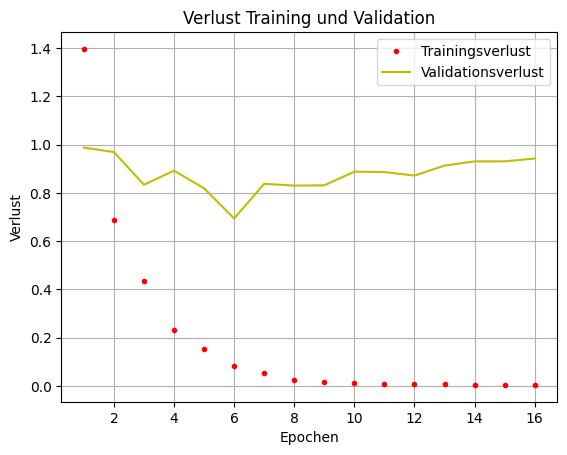

In [9]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'y', label='Validationsverlust')
plt.title('Verlust Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Verlust_2DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Ausgabe der Genauigkeit für Training und Validierung
***

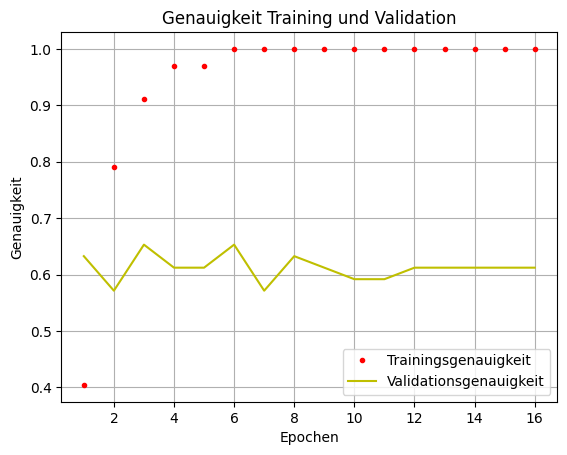

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'r.', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'y', label='Validationsgenauigkeit')
plt.title('Genauigkeit Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Genauigkeit_2DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Modell auf Validierungsdaten anwenden und evaluieren
***

In [11]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Validierungsverlust:", score[0])
print("Validierungsgenauigkeit:", score[1])

Validierungsverlust: 0.9426526427268982
Validierungsgenauigkeit: 0.6122449040412903


### ▶️ Metriken zur Beurteilung der Modellqualität 
***

2/2 [==============================] - 0s 4ms/step


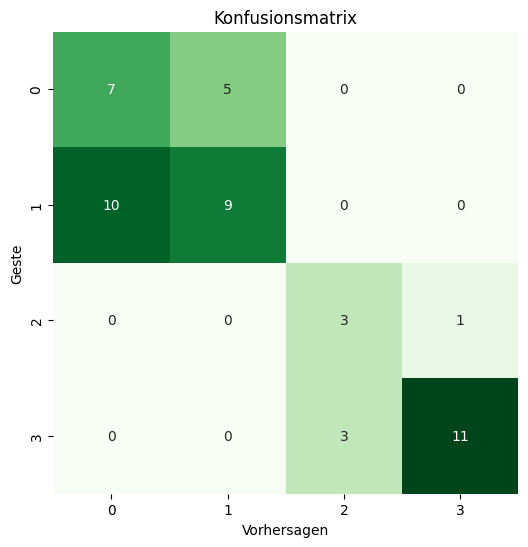

              precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.64      0.47      0.55        19
           2       0.50      0.75      0.60         4
           3       0.92      0.79      0.85        14

    accuracy                           0.61        49
   macro avg       0.62      0.65      0.62        49
weighted avg       0.65      0.61      0.62        49



In [12]:
y_test_arg=np.argmax(y_val,axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))
